# **Prétraitement des Données**

In [5]:
import os
import zipfile
import re
import imghdr
from PIL import Image

import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import cv2
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import random

In [6]:
image_exts=['jpeg','jpg','png']
data_dir='fer2013/train'
for root,dir,files in os.walk(data_dir):
    for file in files:
        file_path=os.path.join(root,file)
        try:
            file_type=imghdr.what(file_path)
            if file_type not in image_exts:
                print(f'Image not in ext list {file_path}')
                os.remove(file_path)
        except Exception as e:
            print(e)
            os.remove(file_path)

In [7]:
def no_of_subdirs(directory,set_name):
    counts={}
    for item in os.listdir(directory):
        item_path=os.path.join(directory,item)
        if os.path.isdir(item_path):
            counts[item]=len(os.listdir(item_path))
    df=pd.DataFrame(counts,index=[set_name])
    return df

<Axes: >

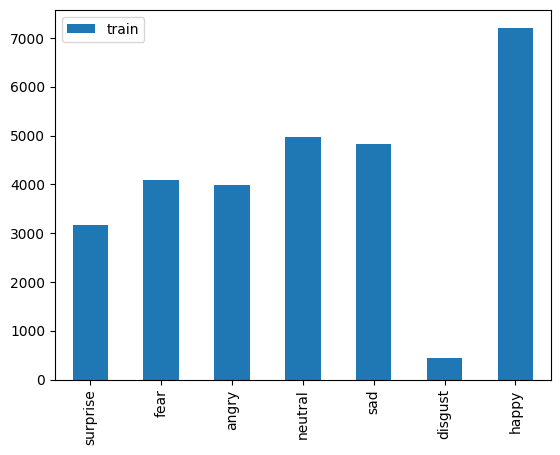

In [ ]:
train_count.transpose().plot(kind='bar')

<Axes: >

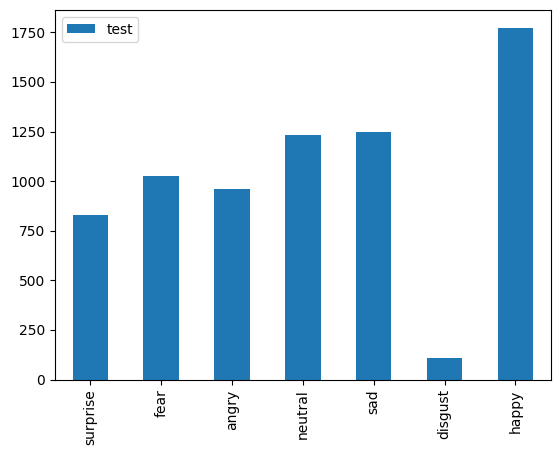

In [ ]:
test_count.transpose().plot(kind='bar')

In [ ]:
img_width,img_height=224,224
batch_size=32
epochs=15
num_classes=7

In [ ]:
# Fonction de prétraitement incluant le filtrage gaussien
def preprocess_image(image):
    # Appliquer le filtre gaussien
    image = cv2.GaussianBlur(image, (5, 5), 0)
    # Redimensionner l'image
    image = cv2.resize(image, (img_width, img_height))
    return image

In [ ]:
# Prétraiter les images dans les répertoires d'entraînement et de test
def preprocess_directory(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                preprocessed_img = preprocess_image(img)
                cv2.imwrite(file_path, preprocessed_img)
            except Exception as e:
                print(e)
                os.remove(file_path)

In [ ]:
preprocess_directory(train_dir)

In [ ]:
preprocess_directory(test_dir)

In [ ]:
data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

In [ ]:
def create_generators(train_dir, test_dir, img_size, batch_size):
    datagen = ImageDataGenerator(rescale=1./255)

    train_generator = datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_generator, test_generator

img_size = (224, 224)
batch_size = 32

# Créer les generators
train_generator, test_generator = create_generators(train_dir, test_dir, img_size, batch_size)


Found 28709 images belonging to 7 classes.

Found 7178 images belonging to 7 classes.


In [ ]:
classes = np.array(train_generator.classes)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)

class_weights_dict = dict(enumerate(class_weights))

print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [ ]:
train_generator.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

# **Détection des Visages avec RetinaNet**

In [ ]:
!pip install torch torchvision matplotlib











  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)


  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)


  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)


  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)


  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)


  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)


  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)


  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)


  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)


  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)


  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)



  Using cached nvidia_n

In [23]:
import torch
from torchvision import models, transforms as T
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
from PIL import Image
import os

In [24]:
model = models.detection.retinanet_resnet50_fpn(pretrained=True)
model = model.eval()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|██████████| 130M/130M [00:00<00:00, 157MB/s]  


In [ ]:
base_model = NASNetLarge(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dense(len(train_generator.class_indices), activation='softmax'))

In [ ]:
# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Résumé du modèle
model.summary()

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 NASNet (Functional)         (None, 7, 7, 4032)        84916818  

                                                                 

 global_average_pooling2d (  (None, 4032)              0         

 GlobalAveragePooling2D)                                         

                                                                 

 dense (Dense)               (None, 128)               516224    

                                                                 

 dense_1 (Dense)             (None, 7)                 903       

                                                                 


Total params: 85433945 (325.90 MB)

Trainable params: 85237277 (325.15 MB)

Non-trainable params: 196668 (768.23 KB)

_________________________________________________________________


In [ ]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator
)

Epoch 1/20


In [ ]:
# Afficher les courbes de performance
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.show()

In [ ]:
def detect_faces(image, net, conf_threshold=0.5):
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    net.setInput(blob)
    detections = net.forward()

    boxes = []
    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            boxes.append((startX, startY, endX, endY))

    return boxes

In [ ]:
def predict_emotions(image, detected_boxes, base_model, model, class_names):
    for box in detected_boxes:
        (startX, startY, endX, endY) = box
        face = image[startY:endY, startX:endX]
        face = cv2.resize(face, (224, 224))
        face = img_to_array(face)
        face = np.expand_dims(face, axis=0) / 255.0

        # Extraire les caractéristiques
        features = base_model.predict(face)
        features = features.reshape(1, -1)

        # Prédire l'émotion
        preds = model.predict(features)[0]
        emotion = class_names[np.argmax(preds)]
        confidence = np.max(preds)

        text = "{}: {:.2f}%".format(emotion, confidence * 100)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        cv2.putText(image, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

    return image

In [ ]:
# Initialiser le flux vidéo
vs = VideoStream(src=0).start()

while True:
    # Lire l'image du flux vidéo
    frame = vs.read()
    frame = imutils.resize(frame, width=400)

    # Détecter les visages
    detected_boxes = detect_faces(frame, net)

    # Prédire les émotions sur les visages détectés
    predicted_frame = predict_emotions(frame, detected_boxes, base_model, model, train_generator.class_indices)

    # Afficher le cadre avec les prédictions
    cv2.imshow("Frame", predicted_frame)

    # Quitter la boucle si 'q' est pressé
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Libérer les ressources
cv2.destroyAllWindows()
vs.stop()

In [ ]:
# Charger les données d'entraînement
train_dir = 'fer2013/train'  # Remplacez par le chemin de votre répertoire d'entraînement
img_size = (331, 331)
X_train, y_train, class_names = load_data(train_dir, img_size)


In [ ]:
# Charger les données de test
test_dir = 'fer2013/test'  # Remplacez par le chemin de votre répertoire de test
X_test, y_test, _ = load_data(test_dir, img_size)

In [ ]:
base_model = NASNetLarge(weights='imagenet', include_top=False, input_shape=(331, 331, 3))

def extract_features(model, data):
    features = model.predict(data)
    return features

# Extraire les caractéristiques des ensembles d'entraînement et de test
train_features = extract_features(base_model, X_train)
test_features = extract_features(base_model, X_test)

# Redimensionner les caractéristiques pour les couches fully connected
train_features = train_features.reshape(train_features.shape[0], -1, train_features.shape[-1])
test_features = test_features.reshape(test_features.shape[0], -1, test_features.shape[-1])


In [ ]:
# Construire le modèle GRU pour la reconnaissance des émotions
model = Sequential()
model.add(GRU(128, input_shape=(train_features.shape[1], train_features.shape[2]), return_sequences=False))
model.add(Dense(len(class_names), activation='softmax'))

In [ ]:
# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Résumé du modèle
model.summary()

In [ ]:
# Entraîner le modèle
history = model.fit(train_features, y_train, epochs=20, validation_data=(test_features, y_test), batch_size=32)

In [ ]:
# Afficher les courbes de performance
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.show()

In [ ]:
# Initialiser le flux vidéo
vs = VideoStream(src=0).start()

while True:
    # Lire l'image du flux vidéo
    frame = vs.read()
    frame = imutils.resize(frame, width=400)

    # Détecter les visages
    detected_boxes = detect_faces(frame, net)

    # Prédire les émotions sur les visages détectés
    predicted_frame = predict_emotions(frame, detected_boxes, base_model, model, class_names)

    # Afficher le cadre avec les prédictions
    cv2.imshow("Frame", predicted_frame)

    # Quitter la boucle si 'q' est pressé
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Libérer les ressources
cv2.destroyAllWindows()
vs.stop()


------------------

In [ ]:
def load_data(data_dir, img_size):
    images = []
    labels = []
    class_names = os.listdir(data_dir)
    class_names.sort()

    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        for file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, file)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            img = img_to_array(img)
            images.append(img)
            labels.append(label)

    images = np.array(images, dtype="float32") / 255.0
    labels = np.array(labels)
    labels = to_categorical(labels, num_classes=len(class_names))

    return images, labels, class_names


In [ ]:
train_dir = 'fer2013/train'
img_size = (331, 331)
X_train, y_train, class_names = load_data(train_dir, img_size)


In [ ]:
test_dir = 'fer2013/test'
X_test, y_test, _ = load_data(test_dir, img_size)

In [ ]:
base_model = NASNetLarge(weights='imagenet', include_top=False, input_shape=(331, 331, 3))

# Fonction pour extraire les caractéristiques
def extract_features(model, data):
    features = model.predict(data)
    return features

# Extraire les caractéristiques des ensembles d'entraînement et de test
train_features = extract_features(base_model, X_train)
test_features = extract_features(base_model, X_test)

# Redimensionner les caractéristiques pour les couches fully connected
train_features = train_features.reshape(train_features.shape[0], -1)
test_features = test_features.reshape(test_features.shape[0], -1)


In [ ]:
# Charger le modèle NASNetLarge pré-entraîné
base_model = NASNetLarge(weights='imagenet', include_top=False, input_shape=(331, 331, 3))

# Ajouter des couches de classification
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dense(len(class_names), activation='softmax'))

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Résumé du modèle
model.summary()


In [ ]:
# Entraîner le modèle
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32)

# Afficher les courbes de performance
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.show()

In [ ]:
def predict_emotions(image, detected_boxes, model, class_names):
    for box in detected_boxes:
        (startX, startY, endX, endY) = box.astype("int")
        face = image[startY:endY, startX:endX]
        face = cv2.resize(face, (331, 331))
        face = img_to_array(face)
        face = np.expand_dims(face, axis=0) / 255.0

        preds = model.predict(face)[0]
        emotion = class_names[np.argmax(preds)]
        confidence = np.max(preds)

        text = "{}: {:.2f}%".format(emotion, confidence * 100)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        cv2.putText(image, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

    return image

# Prédire les émotions sur les visages détectés
predicted_image = predict_emotions(image, detected_boxes, model, class_names)
cv2_imshow(predicted_image)


In [ ]:
from keras.applications import NASNetLarge
from keras.models import Model
from keras.layers import Dense, Flatten, GlobalAveragePooling2D

In [ ]:
base_model = NASNetLarge(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))



343610240/343610240 [==============================] - 9s 0us/step


In [ ]:
# Ajouter des couches de classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [ ]:
# Créer le modèle final
nasnet_model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Compiler le modèle
nasnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Afficher le résumé du modèle
nasnet_model.summary()

Model: "model"

__________________________________________________________________________________________________

 Layer (type)                Output Shape                 Param #   Connected to                  


 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            

                                                                                                  

 stem_conv1 (Conv2D)         (None, 111, 111, 96)         2592      ['input_1[0][0]']             

                                                                                                  

 stem_bn1 (BatchNormalizati  (None, 111, 111, 96)         384       ['stem_conv1[0][0]']          

 on)                                                                                              

                                                                                                  

 activation (Activation)     (None, 111, 111, 96)         0         ['stem_bn1[0][0

# **GRU (Réseau de neurones récurrents)**

In [ ]:
from keras.layers import GRU, TimeDistributed, RepeatVector, Input

In [ ]:
feature_extractor = NASNetLarge(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

In [ ]:
# Récupérer les caractéristiques des images
features_input = Input(shape=(img_width, img_height, 3))
features = feature_extractor(features_input)
features = GlobalAveragePooling2D()(features)

In [ ]:
# Ajouter des couches GRU
x = RepeatVector(1)(features)
x = GRU(256, return_sequences=True)(x)
x = TimeDistributed(Dense(num_classes, activation='softmax'))(x)

In [ ]:
# Créer le modèle final
gru_model = Model(inputs=features_input, outputs=x)

In [ ]:
# Compiler le modèle
gru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Afficher le résumé du modèle
gru_model.summary()

Model: "model_1"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         

                                                                 

 NASNet (Functional)         (None, 7, 7, 4032)        84916818  

                                                                 

 global_average_pooling2d_1  (None, 4032)              0         

  (GlobalAveragePooling2D)                                       

                                                                 

 repeat_vector (RepeatVecto  (None, 1, 4032)           0         

 r)                                                              

                                                                 

 gru (GRU)                   (None, 1, 256)            3294720   

                                                                 

 time_distributed (TimeDist  (None, 1, 7)  

# **SSO**

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [ ]:
# Créer le modèle SSO
sso_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [ ]:
# Compiler le modèle
sso_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Afficher le résumé du modèle
sso_model.summary()

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv2d (Conv2D)             (None, 222, 222, 32)      896       

                                                                 

 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         

 D)                                                              

                                                                 

 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     

                                                                 

 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         

 g2D)                                                            

                                                                 

 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     

                                                                 

 max_pooling2d_2 (MaxPoolin  (None, 26, 

# **Entraînement des Modèles**

In [ ]:
# Entraîner le modèle NASNet-Large
nasnet_model.fit(train_generator, epochs=epochs, validation_data=test_generator, class_weight=class_weights_dict)

NameError: name 'nasnet_model' is not defined

In [ ]:
# Entraîner le modèle GRU
gru_model.fit(train_generator, epochs=epochs, validation_data=test_generator, class_weight=class_weights_dict)

In [ ]:
# Entraîner le modèle SSO
sso_model.fit(train_generator, epochs=epochs, validation_data=test_generator, class_weight=class_weights_dict)

# **Évaluation des Modèles**

In [ ]:
# Évaluer le modèle NASNet-Large
nasnet_model.evaluate(test_generator)

In [ ]:
# Évaluer le modèle GRU
gru_model.evaluate(test_generator)

In [ ]:
# Évaluer le modèle SSO
sso_model.evaluate(test_generator)

# **Préparation pour la Reconnaissance en Temps Réel**

In [ ]:
def preprocess_frame(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (img_width, img_height))
    frame = np.expand_dims(frame, axis=0)
    frame = frame / 255.0
    return frame

In [ ]:
def predict_emotion(frame, model):
    processed_frame = preprocess_frame(frame)
    prediction = model.predict(processed_frame)
    emotion_label = np.argmax(prediction)
    return emotion_label

In [ ]:
# Définir les étiquettes d'émotion
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

In [ ]:
# Capturer des images en temps réel avec OpenCV
cap = cv2.VideoCapture(0)
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Prédire l'émotion avec le modèle NASNet-Large (par exemple)
    emotion_label = predict_emotion(frame, nasnet_model)
    emotion_text = emotion_labels[emotion_label]

    # Afficher le résultat sur le cadre
    cv2.putText(frame, emotion_text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.imshow('Emotion Recognition', frame)

    # Quitter la boucle si 'q' est pressé
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [1]:
!kaggle datasets download -d sudarshanvaidya/random-images-for-face-emotion-recognition

Dataset URL: https://www.kaggle.com/datasets/sudarshanvaidya/random-images-for-face-emotion-recognition
License(s): unknown
 81%|███████████████████████████████▋       | 37.0M/45.6M [00:00<00:00, 202MB/s]
100%|███████████████████████████████████████| 45.6M/45.6M [00:00<00:00, 204MB/s]


In [2]:
!unzip random-images-for-face-emotion-recognition.zip -d random-images-for-face-emotion-recognition

Archive:  random-images-for-face-emotion-recognition.zip
  inflating: random-images-for-face-emotion-recognition/anger/11647173796_033ff06112_n_face.png  
  inflating: random-images-for-face-emotion-recognition/anger/1379351899_7cfa2b0dc4_b_face.png  
  inflating: random-images-for-face-emotion-recognition/anger/14187801814_ea89208940_b_face.png  
  inflating: random-images-for-face-emotion-recognition/anger/22600236939_54d0e01905_n_face.png  
  inflating: random-images-for-face-emotion-recognition/anger/22721287949_65572bea8b_n_face.png  
  inflating: random-images-for-face-emotion-recognition/anger/22913025801_2822113219_n_face.png  
  inflating: random-images-for-face-emotion-recognition/anger/24063912157_38a4f8d093_b_face.png  
  inflating: random-images-for-face-emotion-recognition/anger/2971847861_5c6fe61308_b_face.png  
  inflating: random-images-for-face-emotion-recognition/anger/2Q__ (1)_face.png  
  inflating: random-images-for-face-emotion-recognition/anger/2Q__ (2)_face.png

In [1]:
import os
import numpy as np
import cv2
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical

2024-05-15 18:40:09.223250: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 18:40:09.223356: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 18:40:09.394302: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# Chemins vers les répertoires d'entraînement et de test
data_dir = 'random-images-for-face-emotion-recognition'
train_dir = 'random-images-for-face-emotion-recognition/train'
test_dir = 'random-images-for-face-emotion-recognition/test'
img_size = (224, 224)  # Taille des images
batch_size = 32

In [6]:
# Classes dans le répertoire original
original_classes = os.listdir(data_dir)

# Créer les répertoires d'entraînement et de test s'ils n'existent pas
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Vérifiez et synchronisez les répertoires d'entraînement et de test
for class_name in original_classes:
    if class_name in ['train', 'test']:
        continue  # Ignorer les répertoires d'entraînement et de test existants
    
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        train_class_dir = os.path.join(train_dir, class_name)
        test_class_dir = os.path.join(test_dir, class_name)
        
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)
        
        train_images = os.listdir(train_class_dir)
        test_images = os.listdir(test_class_dir)
        
        # Si une classe manque dans un des ensembles, ajouter des images
        if len(train_images) == 0 or len(test_images) == 0:
            all_images = os.listdir(class_dir)
            train_images, test_images = train_test_split(all_images, test_size=0.2, random_state=42)
            
            for image in train_images:
                src = os.path.join(class_dir, image)
                dst = os.path.join(train_class_dir, image)
                copyfile(src, dst)
            
            for image in test_images:
                src = os.path.join(class_dir, image)
                dst = os.path.join(test_class_dir, image)
                copyfile(src, dst)

In [24]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical'
)

class_names = list(train_generator.class_indices.keys())
print("Classes dans l'ensemble d'entraînement:", len(train_generator.class_indices))
print("Classes dans l'ensemble de test:", len(test_generator.class_indices))

Found 4444 images belonging to 8 classes.
Found 1114 images belonging to 8 classes.
Classes dans l'ensemble d'entraînement: 8
Classes dans l'ensemble de test: 8


In [26]:
# Charger le modèle NASNet-Large pré-entraîné
base_model = NASNetLarge(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fonction pour extraire les caractéristiques par batches
def extract_features(generator, model, batch_size):
    features = []
    labels = []
    for inputs_batch, labels_batch in generator:
        # Ajouter une dimension de couleur pour s'adapter au modèle NASNet
        inputs_batch_rgb = np.concatenate([inputs_batch] * 3, axis=-1)
        features_batch = model.predict(inputs_batch_rgb)
        features.append(features_batch)
        labels.append(labels_batch)
        if len(features) * batch_size >= generator.samples:
            break
    return np.vstack(features), np.vstack(labels)

In [27]:
# Extraire les caractéristiques
train_features, y_train = extract_features(train_generator, base_model, batch_size)
test_features, y_test = extract_features(test_generator, base_model, batch_size)

1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/

In [28]:
# Redimensionner les caractéristiques pour les couches fully connected
train_features = train_features.reshape(train_features.shape[0], -1, train_features.shape[-1])
test_features = test_features.reshape(test_features.shape[0], -1, test_features.shape[-1])

In [29]:
def squirrel_search_optimization(obj_func, lb, ub, dim, num_agents, max_iter):
    # Initialiser la population de solutions (écureuils)
    squirrels = np.random.uniform(low=lb, high=ub, size=(num_agents, dim))
    fitness = np.array([obj_func(s) for s in squirrels])
    
    best_squirrel = squirrels[np.argmin(fitness)]
    best_fitness = np.min(fitness)
    
    for t in range(max_iter):
        for i in range(num_agents):
            if np.random.rand() < 0.5:
                squirrels[i] = squirrels[i] + np.random.uniform(-1, 1) * (best_squirrel - squirrels[i])
            else:
                squirrels[i] = squirrels[i] + np.random.uniform(-1, 1) * (np.random.uniform(lb, ub, dim) - squirrels[i])
            
            # Appliquer les limites inférieure et supérieure
            squirrels[i] = np.clip(squirrels[i], lb, ub)
            
            # Calculer le fitness de la nouvelle position
            new_fitness = obj_func(squirrels[i])
            if new_fitness < fitness[i]:
                fitness[i] = new_fitness
                
                if new_fitness < best_fitness:
                    best_squirrel = squirrels[i]
                    best_fitness = new_fitness
        
        print(f"Iteration {t+1}/{max_iter}, Best Fitness: {best_fitness}")
    
    return best_squirrel, best_fitness

In [30]:
# Fonction pour construire et évaluer le modèle
def build_and_evaluate_model(params):
    learning_rate = params[0]
    gru_units = int(params[1])
    
    model = Sequential()
    model.add(GRU(gru_units, input_shape=(train_features.shape[1], train_features.shape[2]), return_sequences=False))
    model.add(Dropout(0.5))  # Ajouter Dropout pour la régularisation
    model.add(Dense(len(class_names), activation='softmax'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=3)
    history = model.fit(train_features, y_train, epochs=5, batch_size=batch_size, validation_data=(test_features, y_test), callbacks=[early_stopping], verbose=0)
    
    _, accuracy = model.evaluate(test_features, y_test, verbose=0)
    return -accuracy  

In [31]:
# Définir les limites des hyperparamètres
lb = [1e-5, 32]  # Limite inférieure
ub = [1e-2, 512]  # Limite supérieure
dim = 2  # Nombre de dimensions (taux d'apprentissage, unités GRU)
num_agents = 5  # Nombre d'agents (écureuils)
max_iter = 5  # Nombre maximum d'itérations

In [ ]:
from tensorflow.keras.layers import Dense, GRU, Dropout


best_params, best_score = squirrel_search_optimization(build_and_evaluate_model, lb, ub, dim, num_agents, max_iter)

Iteration 1/5, Best Fitness: -0.323159784078598


In [ ]:
print("Meilleurs paramètres trouvés : ", best_params)
print("Meilleur score : ", -best_score)

In [ ]:
best_learning_rate = best_params[0]
best_gru_units = int(best_params[1])

In [12]:
# Construire le modèle GRU pour la reconnaissance des émotions
gru_model = Sequential()
gru_model.add(GRU(128, input_shape=(train_features.shape[1], train_features.shape[2]), return_sequences=False))
gru_model.add(Dense(len(class_names), activation='softmax'))

In [13]:
# Compiler le modèle
gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Résumé du modèle
gru_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 128)            │     1,598,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,599,240 (6.10 MB)

 Trainable params: 1,599,240 (6.10 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Entraîner le modèle
history = gru_model.fit(train_features, y_train, epochs=20, validation_data=(test_features, y_test), batch_size=batch_size)

Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.2950 - loss: 1.9628 - val_accuracy: 0.3752 - val_loss: 1.7114
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5328 - loss: 1.3498 - val_accuracy: 0.3905 - val_loss: 1.6918
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7034 - loss: 0.9467 - val_accuracy: 0.3869 - val_loss: 1.7915
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8271 - loss: 0.6296 - val_accuracy: 0.4210 - val_loss: 1.8287
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9361 - loss: 0.3231 - val_accuracy: 0.3806 - val_loss: 2.0211
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9651 - loss: 0.1869 - val_accuracy: 0.4165 - val_loss: 2.1658
Epoch 7/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9874 - loss: 0.0864 - val_accuracy: 0.4309 - val_loss: 2.2520
Epoch 8/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9928 - loss: 0.0487 - val_accu

In [ ]:
# Sauvegarder le modèle entraîné
#gru_model.save('gru_model.h5')

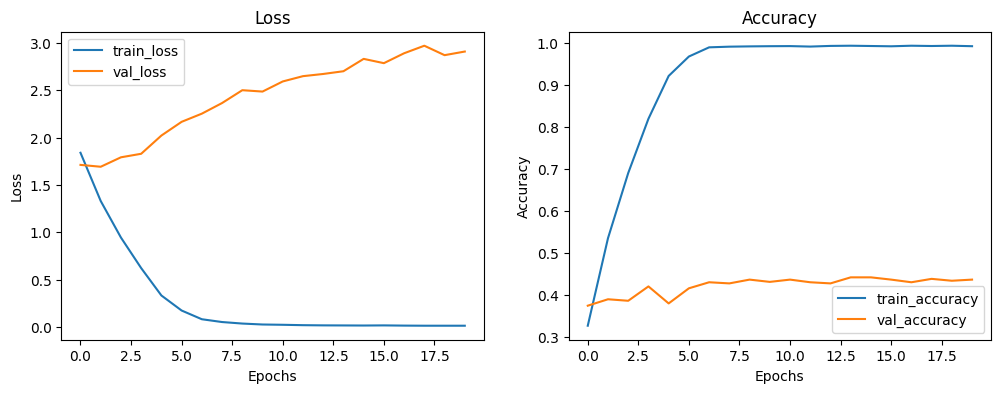

In [17]:
# Afficher les courbes de performance
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.show()

In [ ]:
# Create confusion matrix of our predictions

# compute predictions
predictions = model.predict_generator(generator=val_set)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = val_set.classes
class_names = val_set.class_indices.keys()

# Create function to plot confussion matrix.
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(12,6), dpi=120)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')# **Live Class Monitoring System(Face Emotion Recognition)**
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()